In [ ]:
import imutils
from imutils.contours import sort_contours
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import csv


##the function bellow aims to find and sort contours input images##

def find_contours(img):
    # preprocess the image by blurring to remove noise and converting to grey scale
    to_grey_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    to_blurred = cv2.GaussianBlur(to_grey_scale, (1, 1), 0)
    (thresh, bw) = cv2.threshold(to_blurred, 100, 255, cv2.THRESH_BINARY) #change here

    # detect the edges
    # compute the lower and upper threshold for canny method
    sigma = 0.23  # default value
    median_pix = np.median(img)
    lower = int(max(0, (1 - sigma) * median_pix))
    upper = int(min(255, (1 + sigma) * median_pix))
    # get the edged image
    to_edged = cv2.Canny(bw, lower, upper)
  

    # find and sort contours from left to right
    contours = cv2.findContours(
        to_edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left_to_right")[0]
    return contours


##The function below finds bounding boxes of an input image


def find_bounding_box(img):

    characters = []

    contours = find_contours(img)
    paddedArray = []
    for contour in contours:
        # get the bounding box for each contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # extract the character and threshold it

        to_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cropped = to_gray[y : y + h, x : x + w]
        thresholded = cv2.threshold(
            cropped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
        )[1]
        (H, W) = thresholded.shape
        #print(H,W)
        if H<10:
          continue
        if W<10:
          continue

        # make 32x32 pixels
        # output = cv2.resize(thresholded, (32,32))
        if W > H:
            thresholded = imutils.resize(thresholded, width=28)
        # otherwise, resize along the height
        else:
            thresholded = imutils.resize(thresholded, height=28)

        # pad instead of extending
        (H, W) = thresholded.shape
        X_padding = int(
            max(0, 28 - W) / 2.0
        )  # if W =32 we won't need to pad on the X-axis
        Y_padding = int(
            max(0, 28 - H) / 2.0
        )  # if H = 32 we won't need to padd on the y-axis

        # pad the image and force 32x32 dimensions
        padded = cv2.copyMakeBorder(
            thresholded,
            top=Y_padding,
            bottom=Y_padding,
            left=X_padding,
            right=X_padding,
            borderType=cv2.BORDER_CONSTANT,
            value=(0, 0, 0),
        )

        padded = cv2.resize(padded, (64, 64))
        paddedArray.append(padded)
        # add character image and dimension from original image into the characters array
        characters.append((padded, (x, y, w, h)))

    return characters, paddedArray






In [ ]:
from skimage import exposure
import joblib 

# Load the saved model
svc = joblib.load('/content/drive/MyDrive/Models/best_model_knn.pkl')
knn = joblib.load('/content/drive/MyDrive/Models/best_model_svc.pkl')
mlp = joblib.load('/content/drive/MyDrive/Models/best_model_mlp.pkl')


In [ ]:
def crop_nb(img,Thresh):


  img_eq = exposure.equalize_hist(img)

  # Upscale the image to double its size using bicubic interpolation
  img = cv2.resize(img,(img.shape[1]*4, img.shape[0]*4))
  
  # Get the dimensions of the image
  height, width, channels = img.shape

  # Set the crop box dimensions
  left = int(width * 0.5)
  top = int(height * 0.8)
  right = int(width*0.93)
  bottom = int(height*0.9)  # 25% of the bottom


  #  Crop the image
  cropped_img = img[top:bottom, left:right]
  img = cv2.threshold(cropped_img, Thresh, 255, cv2.THRESH_BINARY)[1] #change here
  return img

60
65
70
75
80
85
90
95
100
105
110
115


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


120
125
130
135
140
145
150


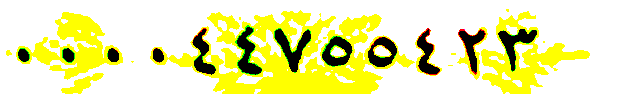

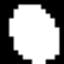

[0] [0] [0]


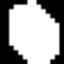

[0] [0] [0]


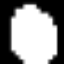

[0] [0] [0]


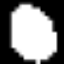

[0] [0] [0]


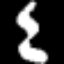

[4] [4] [4]


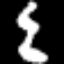

[4] [4] [4]


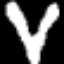

[7] [7] [7]


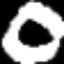

[0] [5] [0]


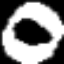

[5] [5] [5]


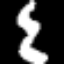

[4] [4] [4]


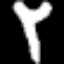

[2] [2] [2]


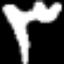

[3] [3] [3]


In [ ]:
img =cv2.imread("/content/drive/MyDrive/ProcessedImages/id1.jpg")

img2=[]

ThreshSet = False
Thresh = 60
while ThreshSet== False and Thresh<255 :
  try:
    print(Thresh)
    img2 = crop_nb(img,Thresh)
    #cv2_imshow(img)
    char,padd = find_bounding_box(img2)
    if len(padd) == 12:
      cv2_imshow(img2)
      ThreshSet= True
      for i in padd:
        show =cv2_imshow(i)
        resized =  cv2.resize(i, (28, 28))
        x = [resized.flatten(),]
        print(knn.predict(x),
              svc.predict(x),mlp.predict(x))
    else:
      Thresh+=5
  except: 
    Thresh+= 5